# Week 4: Image Segmentation
### Date: 26 Oct 2023

Last week you learned about different methods for segmenting an image into regions of interest and coding some algorithms. In this session you will get some more experience coding image segmentation algorithms. Your task will be to code a simple statistical method that uses Region growing or connected components.

In [1]:
import numpy as np
import copy
import cv2
# to visualize the plots within the notebook
%matplotlib inline
# to enable interactive
#%matplotlib ipympl
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import random
from PIL import Image

## Task 1: Region growing
Region growing is a simple way to segment a region of interest from the background of an image.
It takes in a gray-scale image and produces a binary image as output, where a value of 1 represents the region of interest and a value of 0 represents the background.

The algorithm is:
1. Start from a seed pixel.
2. Add neighbouring pixels that satisfy the criteria defining a region (e.g. similar intensity values, intensity above a threshold).
3. Repeat until we can include no more pixels.

Your task is to write a function in Python that implements the region growing algorithm.
Something like:
```
  segmented_img = region_growing(img, x, y)
```

* img: the image to be segmented
* x: the x-coordinate (j if indexed by numpy array) of the seed pixel
* y: the y-coordinate (i if indexed by numpy array) of the seed pixel
* segmented_img: the binary image output of region growing

**Hint:** This is process basically a **Breadth-first Search (BFS)**, which could be easily implemented it with a **queue** (check out collections.deque in PyThon): 

1. Initialise the queue with the seed pixel. 
2. Every time pop the first element from the queue and add its neighbour pixels to the queue if they satisfy the criteria (e.g. intensity above the threshold).
3. Finish when the queue is empty

In the slide 36 in the lecture slides, you were given a slightly different implementation, where all the neighboring pixels are added to the queue and the check is done when the element is popped from the queue. Think about the difference between these two implementations.

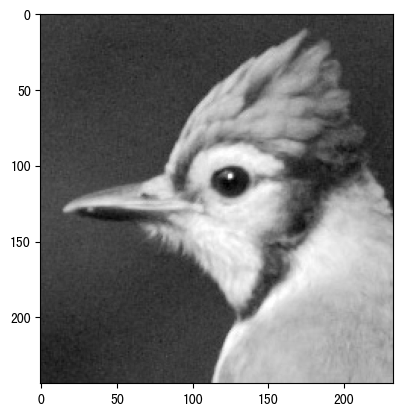

In [3]:
# Load your image
img = cv2.imread('../images/sample_image.jpg')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)
plt.imshow(gray_img, 'gray')
plt.show()

In [9]:
from collections import deque
def region_growing(img, x, y, thresh=100, connectedness=4):
    '''
    Impelemnt region growing algorithm to segment a gray scaled image into regions
    :param img: gray scaled image [H, W]
    :param x, y: coordinate of the seed pixel
    :param thresh: region growing threshold
    :return: segmented image [H, W]
    '''
    assert img.ndim == 2, "Expect a gray-scale image!!!"
    # Write your own code here
    
    height, width = img.shape
    
    visited = np.zeros((height, width))
    
    boundary = deque()
    boundary.append((x, y))
    visited[x, y] = 1
    
    # define neighbors based on connectedness
    if connectedness == 4:
        neighbors = [(0, 1), (1, 0), (0, -1), (-1, 0)]
    elif connectedness == 8:
        neighbors = [(0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1), (-1, 0), (-1, 1)]
    else:
        raise ValueError("Connectedness should be 4 or 8.")
    
    
    while boundary:
        current_x, current_y = boundary.popleft()
        
        for dx, dy in neighbors:
            new_x = current_x + dx
            new_y = current_y + dy
            if 0 <= new_x < height and 0 <= new_y < width:
                if visited[new_x, new_y] == 0. and img[new_x, new_y] >= thresh:
                    boundary.append((new_x, new_y))
                    visited[new_x, new_y] = 1
                    
    return visited

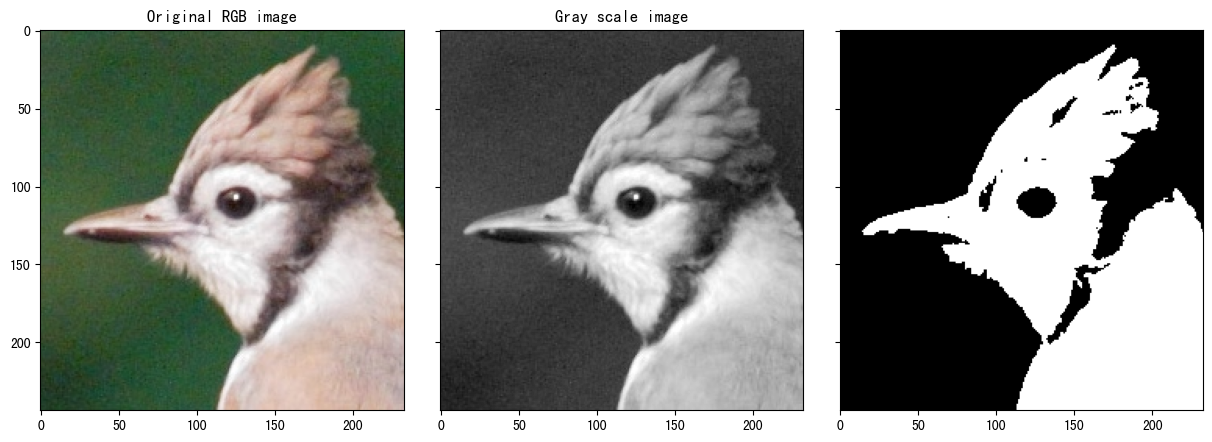

In [26]:
# define set of seed pixel points
x, y = 100, 100

# run region growing algorithm
seg_img = region_growing(gray_img, x, y, thresh=100, connectedness=4)

# Show Original and segmented image
fig, axis = plt.subplots(1, 3, figsize=(15,10), sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.05)
axis[0].imshow(img)
axis[0].set_title('Original RGB image')

axis[1].imshow(gray_img, 'gray')
axis[1].set_title('Gray scale image')
# axis[1].plot(100,100, 'xr')

axis[2].imshow(seg_img, 'gray')

plt.show()

### There are two important factors that influence the performance of a region growing algorithm.

#### 1. The first is the seed pixel selection.
Try the following:
1. Pick a random pixel in the image.
2. Plot the histogram of the image, select a reasonable threshold and then search for a pixel whose intensity value is above the threshold (look for the `matplotlib.pyplot.hist()` function).
3. Do it manually (Hint: You can do this by enabling the interactive mode for `matplotlib`).

Which one is better?

(array([[  0.,  51., 181., ...,   0.,   0.,   0.],
        [  1.,  44., 187., ...,   0.,   0.,   0.],
        [  0.,  46., 183., ...,   0.,   0.,   0.],
        ...,
        [  0.,  74.,  50., ...,  56.,   0.,   0.],
        [  0.,  74.,  53., ...,  41.,   0.,   0.],
        [  0.,  86.,  43., ...,  38.,   0.,   0.]]),
 array([ 16. ,  39.9,  63.8,  87.7, 111.6, 135.5, 159.4, 183.3, 207.2,
        231.1, 255. ], dtype=float32),
 <a list of 233 BarContainer objects>)

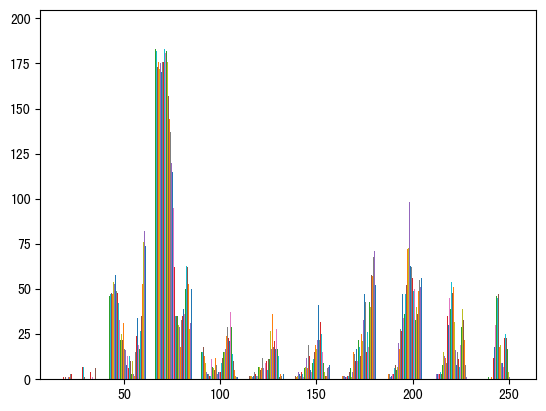

In [11]:
plt.hist(gray_img)

<mark>**Comment:**</mark><br>
As we can see from the histogram of the image, most of the background pixels are lands between 63.8 and 87.7. Therefore, the threshold should be set at least above 87.7, but not too high to segment background and foreground.

#### 2. The second important factor is how to decide whether to add a neighbouring pixel to the existing region. 

Again, there are different options. Try the following alternatives:

1. Compare the pixel intensity value of the neighbours to a specified threshold (try the pixel intensity value of the initial seed pixel). If it is larger, then add it to the region. Depending on the seed pixel you might consider adding pixels with smaller intensities or even using a range of valid intensity values.
    
2. Compare the pixel intensity value of the neighbours to the average pixel intensity value of the existing region. How will we decide when to add neighbours to the region in this case?

Which one is better?

In [22]:
# 1.
def region_growing_2(img, x, y, connectedness=4):
    '''
    Impelemnt region growing algorithm to segment a gray scaled image into regions
    :param img: gray scaled image [H, W]
    :param x, y: coordinate of the seed pixel
    :param thresh: region growing threshold
    :return: segmented image [H, W]
    '''
    assert img.ndim == 2, "Expect a gray-scale image!!!"
    # Write your own code here
    
    height, width = img.shape
    
    visited = np.zeros((height, width))
    
    boundary = deque()
    boundary.append((x, y))
    visited[x, y] = 1
    
    # define neighbors based on connectedness
    if connectedness == 4:
        neighbors = [(0, 1), (1, 0), (0, -1), (-1, 0)]
    elif connectedness == 8:
        neighbors = [(0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1), (-1, 0), (-1, 1)]
    else:
        raise ValueError("Connectedness should be 4 or 8.")
    
    
    while boundary:
        current_x, current_y = boundary.popleft()
        
        for dx, dy in neighbors:
            new_x = current_x + dx
            new_y = current_y + dy
            if 0 <= new_x < height and 0 <= new_y < width:
                if visited[new_x, new_y] == 0. and img[new_x, new_y] >= img[x,y]:
                    boundary.append((new_x, new_y))
                    visited[new_x, new_y] = 1
                    
    return visited

In [23]:
# 3.
def region_growing_3(img, x, y, offset=50, connectedness=4):
    '''
    Impelemnt region growing algorithm to segment a gray scaled image into regions
    :param img: gray scaled image [H, W]
    :param x, y: coordinate of the seed pixel
    :return: segmented image [H, W]
    '''
    assert img.ndim == 2, "Expect a gray-scale image!!!"
    # Write your own code here
    
    height, width = img.shape
    
    visited = np.zeros((height, width))
    
    boundary = deque()
    boundary.append((x, y))
    visited[x, y] = 1
    
    exist_region = []
    exist_region.append(img[x, y])
    
    # define neighbors based on connectedness
    if connectedness == 4:
        neighbors = [(0, 1), (1, 0), (0, -1), (-1, 0)]
    elif connectedness == 8:
        neighbors = [(0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1), (-1, 0), (-1, 1)]
    else:
        raise ValueError("Connectedness should be 4 or 8.")
    
    
    while boundary:
        current_x, current_y = boundary.popleft()
        
        for dx, dy in neighbors:
            new_x = current_x + dx
            new_y = current_y + dy
            if 0 <= new_x < height and 0 <= new_y < width:
                if visited[new_x, new_y] == 0. and (np.mean(exist_region) - offset) <= img[new_x, new_y] <= (np.mean(exist_region) + offset):
                    boundary.append((new_x, new_y))
                    visited[new_x, new_y] = 1
                    exist_region.append(img[new_x, new_y])
                    
    return visited


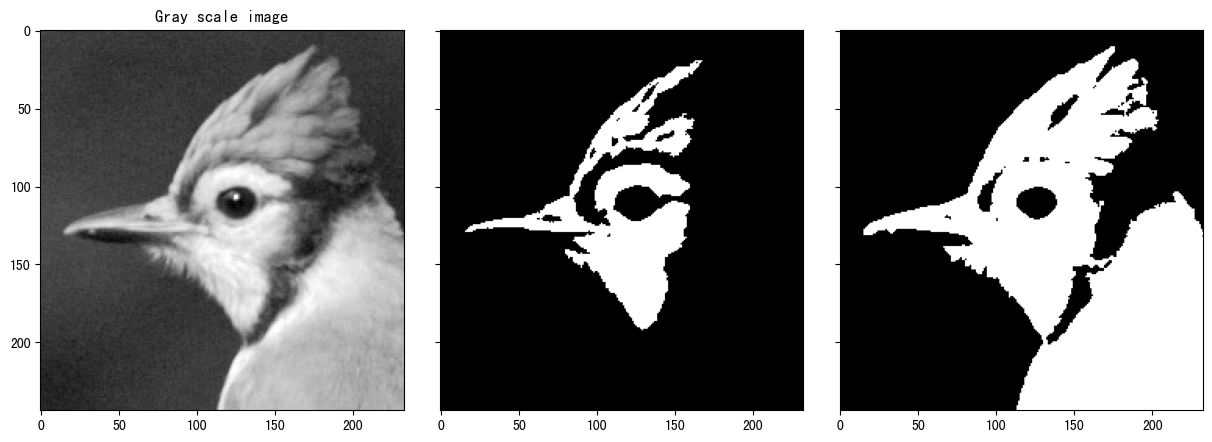

In [29]:
# define set of seed pixel points
x, y = 100, 100

# run region growing algorithm
seg_img_2 = region_growing_2(gray_img, x, y, connectedness=4)
seg_img_3 = region_growing_3(gray_img, x, y, offset=80, connectedness=4)

# Show Original and segmented image
fig, axis = plt.subplots(1, 3, figsize=(15,10), sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.05)
axis[0].imshow(gray_img, 'gray')
axis[0].set_title('Gray scale image')

axis[1].imshow(seg_img_2, 'gray')

axis[2].imshow(seg_img_3, 'gray')

plt.show()

<mark>**Comments:**</mark><br>
*First option:*<br>
pros: easy to implement & operation speed is fast <br>
cons: only consider intensity value of the initial pixel, which result in the effect highly depend on the initialization. <br>
*Second option:*<br>
pros: take all the existing region into account, the result really depend on the offset against the region. <br>
cons: if the offset is large, the operation speed will be slow. <br>

### More things to try out:
1. What kind of connectivity did you use for considering neighbour pixels? If you used 4- connectivity, try 8-connectivity, if you used 8-connectivity then try 4-connectivity.
    Does this change results?
    
2. What if there are multiple regions of interest? Consider using multiple seed points. How will you choose these?

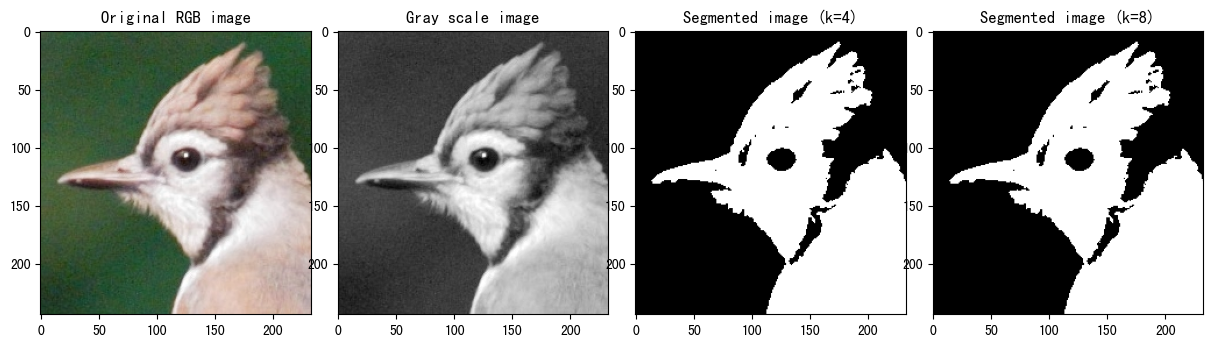

In [30]:
# 1.
# define set of seed pixel points
x, y = 100, 100

# run region growing algorithm
seg_img = region_growing(gray_img, x, y, thresh=100, connectedness=4)
seg_img2 = region_growing(gray_img, x, y, thresh=100, connectedness=8)

# Show Original and segmented image
fig, axis = plt.subplots(1, 4, figsize=(15,15))
fig.subplots_adjust(wspace=0.1, hspace=0.05)
axis[0].imshow(img)
axis[0].set_title('Original RGB image')

axis[1].imshow(gray_img, 'gray')
axis[1].set_title('Gray scale image')

axis[2].imshow(seg_img, 'gray')
axis[2].set_title('Segmented image (k=4)')

axis[3].imshow(seg_img2, 'gray')
axis[3].set_title('Segmented image (k=8)')
plt.show()

Are the 2 results really identical?
 False


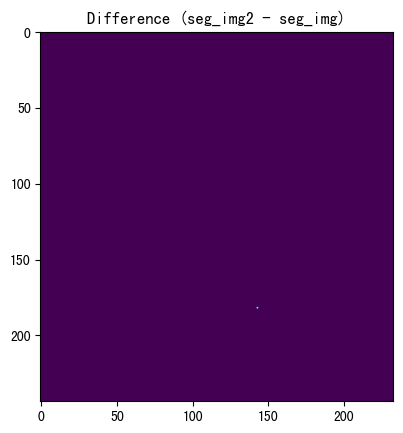

In [31]:
# the result looks sames, test if the two results are really identical
result = np.array_equal(seg_img, seg_img2)
print('Are the 2 results really identical?\n', result)
plt.imshow(abs(seg_img2 - seg_img))
plt.title('Difference (seg_img2 - seg_img)')
plt.show()

In [32]:
# multiple regions of interest
def region_growing_4(img, x1, y1, x2, y2, connectedness=4):
    '''
    Impelemnt region growing algorithm to segment a gray scaled image into regions
    :param img: gray scaled image [H, W]
    :param x, y: coordinate of the seed pixel
    :return: segmented image [H, W]
    '''
    assert img.ndim == 2, "Expect a gray-scale image!!!"
    # Write your own code here
    
    height, width = img.shape
    
    visited = np.zeros((height, width))
    
    boundary1 = deque()
    boundary1.append((x1, y1))
    boundary2 = deque()
    boundary2.append((x2, y2))
    visited[x1, y1] = 1
    visited[x2, y2] = 2
    
    # define neighbors based on connectedness
    if connectedness == 4:
        neighbors = [(0, 1), (1, 0), (0, -1), (-1, 0)]
    elif connectedness == 8:
        neighbors = [(0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1), (-1, 0), (-1, 1)]
    else:
        raise ValueError("Connectedness should be 4 or 8.")
    
    while boundary1:
        current_x, current_y = boundary1.popleft()
        
        for dx, dy in neighbors:
            new_x = current_x + dx
            new_y = current_y + dy
            if 0 <= new_x < height and 0 <= new_y < width:
                if visited[new_x, new_y] == 0. and img[new_x, new_y] >= img[x1, y1]:
                    boundary1.append((new_x, new_y))
                    visited[new_x, new_y] = 1
                
    while boundary2:
        current_x, current_y = boundary2.popleft()
        
        for dx, dy in neighbors:
            new_x = current_x + dx
            new_y = current_y + dy
            if 0 <= new_x < height and 0 <= new_y < width:
                if visited[new_x, new_y] == 0. and img[new_x, new_y] >= img[x2, y2]:
                    boundary2.append((new_x, new_y))
                    visited[new_x, new_y] = 2
                    
    return visited

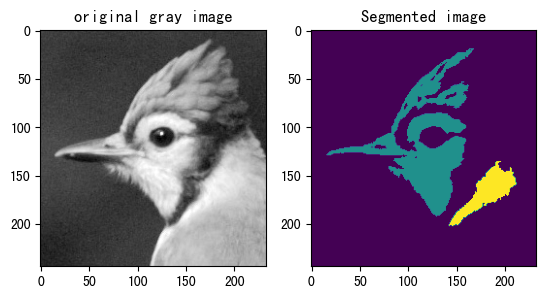

In [33]:
# define set of seed pixel points
x1, y1 = 100, 100
x2, y2 = 150, 180

# run region growing algorithm
seg_img_4 = region_growing_4(gray_img, x1, y1, x2, y2, connectedness=4)

plt.subplot(1, 2, 1)
plt.imshow(gray_img, cmap='gray')
plt.title('original gray image')
plt.subplot(1, 2, 2)
plt.imshow(seg_img_4)
plt.title('Segmented image')
plt.show()

## Task 2: Connected Components 

Connected-component labeling (also known as connected-component analysis, or region labeling) is an algorithmic application of graph theory that is used to determine the connectivity of “blob”-like regions in a binary image.
Specifically, the algorithm labels each connected component of a binary image with a separate number.

Similar to Region Growing, for a single connected-component we can start from a seed and iteratively traverse all the neighbouring pixels. In this case,you can perform Depth-first Serach (DFS). Then we just need to repeat this process for all the connected components in the image.

Hint: In the lecture slide you were given as recursive implementation for DFS, but iterative implementation is more efficient.

In [34]:
def connected_components_label(img, connectedness=4):
    # Write your own code here
    
    height, width = img.shape
    
    visited = np.zeros_like(img)
    
    boundary = []
    
    if connectedness == 4:
        neighbors = [(0, 1), (1, 0), (0, -1), (-1, 0)]
    # define neighbors based on connectedness
    elif connectedness == 8:
        neighbors = [(0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1), (-1, 0), (-1, 1)]
    else:
        raise ValueError('Connectedness should be 4 or 8.')
 
    n = 1
    for i in range(height):
        for j in range(width):
            if img[i, j] and visited[i, j] == 0.:
                boundary.append((i, j))
                while boundary:
                    x, y = boundary.pop()
                    visited[x, y] = n
                    for dx, dy in neighbors:
                        new_x = x + dx
                        new_y = y + dy
                        if 0 <= new_x < height and 0 <= new_y < width:
                            if img[new_x, new_y] and visited[new_x, new_y] == 0.:
                                boundary.append((new_x, new_y))
                n += 1  

    return visited

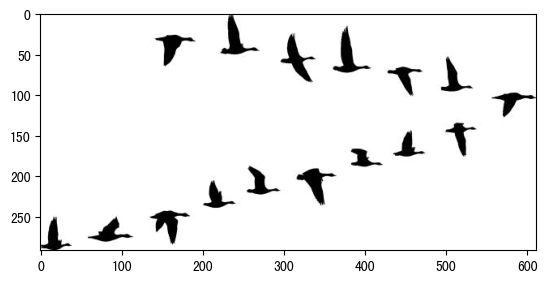

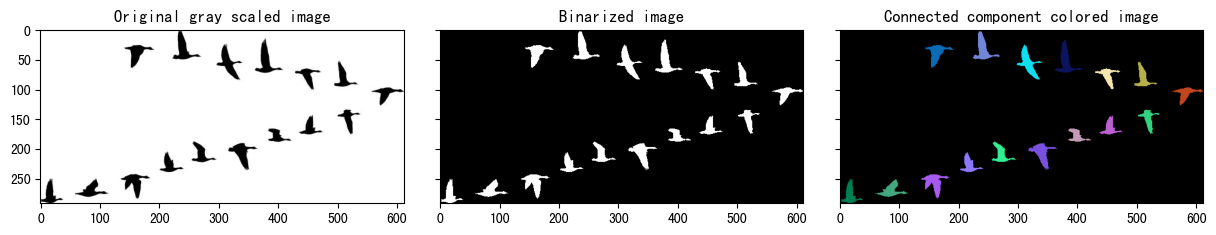

In [36]:
from utils import colourize

img2 = cv2.imread("../images/gooses.jpg")
gray_img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY).astype(np.float32)
plt.imshow(gray_img2, 'gray')

bimg2 = (gray_img2 < 100).astype(np.float32)
ccl_img2 = connected_components_label(bimg2)

fig, axis = plt.subplots(1, 3, figsize=(15,10), sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.05)
axis[0].imshow(gray_img2, 'gray')
axis[0].set_title('Original gray scaled image')

axis[1].imshow(bimg2, 'gray')
axis[1].set_title('Binarized image')

axis[2].imshow(colourize(ccl_img2))
axis[2].set_title('Connected component colored image')
plt.show()

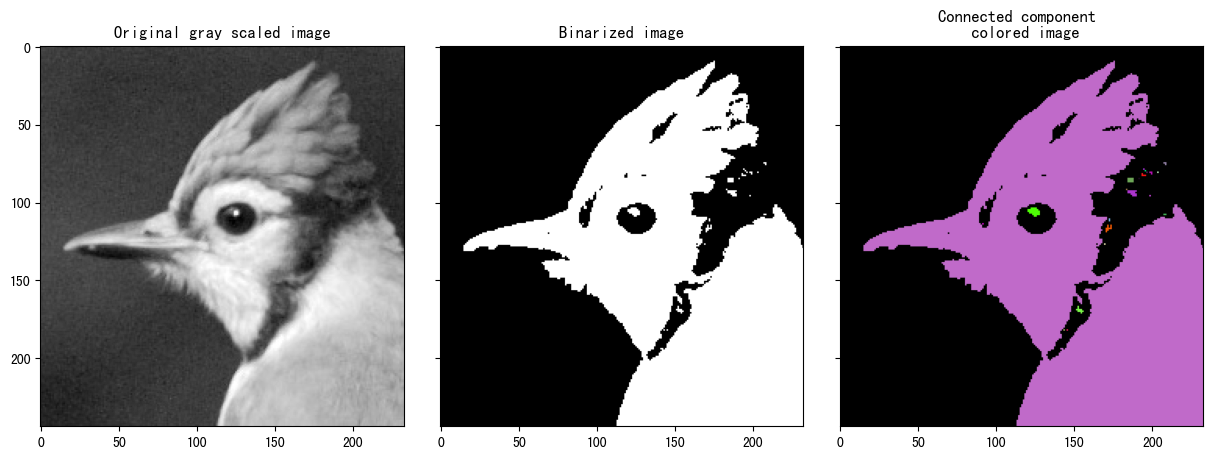

In [37]:
bimg = (gray_img > 100).astype(np.float32)
ccl_img = connected_components_label(bimg)

fig, axis = plt.subplots(1, 3, figsize=(15,10), sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.05)
axis[0].imshow(gray_img, 'gray')
axis[0].set_title('Original gray scaled image')

axis[1].imshow(bimg, 'gray')
axis[1].set_title('Binarized image')

axis[2].imshow(colourize(ccl_img))
axis[2].set_title('Connected component \n colored image')
plt.show()